## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
((df['group'] == 'treatment') != (df['landing_page'] =='new_page' )).sum()

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[(df['group'] == 'treatment') == (df['landing_page'] =='new_page' )]
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(subset = 'user_id', keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(subset = 'user_id', keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(index = 1899, inplace = True)

/Users/gongmengyan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [14]:
df2['user_id'].nunique()

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == "new_page").mean()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**The conversion rate for the new treatment page is less than the conversion rate for the old page. However, without any statistic test, there is no sufficient evidence to say that the new treatment page leads to less or more conversions**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null: $p_{new}$ <= $p_{old}$**

**Alternative: $p_{new}$ > $p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2[df2['landing_page'] == "new_page"]['converted'].count()
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2[df2['landing_page'] == "old_page"]['converted'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new = df2['converted']
new_page_converted = np.random.choice(new, size = n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old = df2['converted']
old_page_converted = np.random.choice(old, size = n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.00128235061247442

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(new, size = n_new)
    old_page_converted = np.random.choice(old, size = n_old)
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

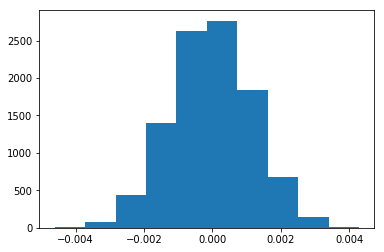

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# calculate the actual difference observed in ab_data.csb
p_diff = df2.query('group == "treatment"')['converted'].mean()- \
         df2.query('group == "control"')['converted'].mean()

# tranfrom list to array
p_diffs = np.asarray(p_diffs)

# calcualte the proportion of the p_diffs are greater than zero.
(p_diffs > p_diff).mean()

0.9045

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value I just computed in part j is the probability of observing the conversion rate difference in favor of the alternative if the null hypothesis is true. It is called p-value in scientific studies. Since the p-value is larger than type I error rate of 0.05, it means I can't reject the null hypothesis and the new page doesn't have a higher conversion rate than the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2[df2['landing_page'] == "old_page"]['converted'].sum()
convert_new = df2[df2['landing_page'] == "new_page"]['converted'].sum()
n_old = df2[df2['landing_page'] == "old_page"]['converted'].count()
n_new = df2[df2['landing_page'] == "new_page"]['converted'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [43]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([convert_new,convert_old])
nobs = np.array([n_old, n_new])
stat, pval = proportions_ztest(count, nobs, alternative = 'larger',\
                               prop_var = df2['converted'].var())
print('{0:0.3f}'.format(stat),'{0:0.3f}'.format(pval))

-1.334 0.909


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score means the observed conversion rate for the new page is less than the observed conversion rate for the old page. p-value means that the conversion rate for the new page is not significantly higher than the conversion rate for the new page. This is consistent with the findings in parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
# create a dummy variable for group
df2[['page','ab_page']] = pd.get_dummies(df['group'])
df2.drop(['page'], axis=1, inplace = True)

#add an intercept column
df2['intercept'] = 1

df2.head()

/Users/gongmengyan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/gongmengyan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/gongmengyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
import statsmodels.api as sm
logit_mod = sm.Logit(df2['converted'], df2[['ab_page', 'intercept']])
res = logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        19:13:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**The coefficient for ab_page is -0.015, which means that conversion rate for new papge (treatment) is 0.985 times of the old page(control). But, since the p-value associated with ab_papge is 0.19, which is higher than type I error of 0.05. It indicates that the null hypothesis cannot be rejected. That is there is no significant association between conversion rate for new page and old page.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page is 0.19. This value is different from the value I found in Part II due to the differences of the null hypothesis of logistic regression and Z-test. The null hypothesis for logistic regression is the coffecients on the ab_papge for the logistic regression modeling log(odds) of converted is zero so that a two-tailed test was conducted in Part III. The null hypothesis for Z-test is the conversion rate for new papge is less than or equal to the conversion rate for old pape, i.e. $p_{new}$ <= $p_{old}$, so that one-talied test was conducted in Part II.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**We might need to consider the influence of the time period on the test result. If the test is short, it may produce bias results when tested on existing users, due to factors like change aversion and novelty effect. Adding additional terms will increase the complexity of the model and may also introduce some problems like multicollinearity.**

In [33]:
# check the time period in the data
df2.timestamp.max(), df2.timestamp.min()

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

In [34]:
# create catogorical variable for day of the user view the website
# 2-12: between 2017-01-02 and 2017-01-12, 13-24: between 2017-01-13 and 2017-01-24
df2['day'] = np.where(pd.DatetimeIndex(df2['timestamp']).day <= 12, '2-12', '13-24')
df2.head()

/Users/gongmengyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,timestamp,group,landing_page,converted,ab_page,intercept,day
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,13-24
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,2-12
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,2-12
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,2-12
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,13-24


In [35]:
# create dummy variable for day of the user view the website
df2[['day1', 'day2']] = pd.get_dummies(df2['day'])

/Users/gongmengyan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [36]:
# conduct logistic regression to see if page and the time period
# that user visit website influence the conversion rate
logit_mod = sm.Logit(df2['converted'], df2[['ab_page','day2','intercept']])
res = logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 06 Mar 2019   Pseudo R-squ.:               1.323e-05
Time:                        19:13:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2448
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.309      0.191      -0.037       0.007
day2          -0.0120      0.011     -1.047      0.295      -0.034       0.010
intercept     -1.9831      0.010   -204.358      0.000      -2.002      -1.964
==============================================================================
"""

**The p-value for the cofficients associated with ab_page, day2 are all larger than 0.05, which indicate that the associated associates are not sigificant from zero. Hence, within the time period in the data, the observation period has no impact on conversion.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
# read data for which country a user lives
countries_df = pd.read_csv('./countries.csv')

# merge two data sets
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

# check the first five lines for new data set
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,day,day1,day2
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,13-24,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,13-24,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,13-24,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,13-24,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,13-24,1,0


In [38]:
# Check the unique values for country
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
# Create the necessary dummy variables
df_new[['CA','UK', 'US']] = pd.get_dummies(df_new['country'])

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,day,day1,day2,CA,UK,US
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,13-24,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,13-24,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,13-24,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,13-24,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,13-24,1,0,0,1,0


In [40]:
# conduct logistic regression
logit_mod = sm.Logit(df_new['converted'], df_new[['ab_page', 'CA', 'UK', 'intercept']])
res = logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        19:13:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
==============================================================================
"""

**The p-value for the cofficients associated with ab_page, CA, and CK are all larger than 0.05, which indicate that the associated associates are not sigificant from zero. Hence, the country has no impact on conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
## Fit Your Linear Model And Obtain the Results
df_new['CA_page'] = df_new['CA']*df_new['ab_page']
df_new['UK_page'] = df_new['UK']*df_new['ab_page']
logit_mod = sm.Logit(df_new['converted'], df_new[['ab_page', 'CA', 'UK', 'CA_page', 'UK_page','intercept']])
res = logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Mar 2019   Pseudo R-squ.:               3.482e-05
Time:                        19:13:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
==============================================================================
"""

**The p-value for the cofficients associated with ab_page, CA, CK, CA_page, and CK_papge are all larger than 0.05, which indicate that the associated associates are not sigificant from zero. Hence, the interction between papge and country has no impact on conversion.**

<a id='conclusions'></a>
## Conclusions

**With currently avaliable data, it seems that implementation of new page does't increase the conversion rate significantly. I would suggest the company to keep the old page, or perhaps run the experiment longer to make their decision.**